In [1]:
#######################################################################
############     Plots for NN model : SIDIS           #################
############ Written by Ishara Fernando & Nick Newton #################
############ Last upgrade: Oct-19-2021 ################################
#######################################################################

import tensorflow as tf
import pandas as pd
import numpy as np
import lhapdf
import matplotlib.pyplot as plt

import functions


In [7]:
class A0(tf.keras.layers.Layer):
    def __init__(self, kperp2avg=.57, pperp2avg=.12, **kwargs):
        super(A0, self).__init__(name='a0')
        self.m1 = tf.Variable(1., name='m1')
        self.kperp2avg = kperp2avg
        self.pperp2avg = pperp2avg
        self.e = tf.constant(1.)
        
    def get_config(self):
        config = super().get_config().copy()
        
        config.update({
            'kperp2avg': self.kperp2avg,
            'pperp2avg': self.pperp2avg
        })
        
        return config
        
    def call(self, inputs):
        z = inputs[:, 0]
        pht = inputs[:, 1]
        ks2avg = (self.kperp2avg*self.m1**2)/(self.m1**2 + self.kperp2avg) #correct 
        topfirst = (z**2 * self.kperp2avg + self.pperp2avg) * ks2avg**2 #correct
        bottomfirst = (z**2 * ks2avg + self.pperp2avg)**2 * self.kperp2avg #correct
        exptop = pht**2 * z**2 * (ks2avg - self.kperp2avg) #correct
        expbottom = (z**2 * ks2avg + self.pperp2avg) * (z**2 * self.kperp2avg + self.pperp2avg) #correct
        last = tf.sqrt(2*self.e) * z * pht / self.m1 #correct      
        return (topfirst/bottomfirst) * tf.exp(-exptop/expbottom) * last

class Quotient(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Quotient, self).__init__()
    
    def call(self, inputs):
        if len(inputs) != 2 or inputs[0].shape[1] != 1:
            raise Exception('must be two tensors of shape (?, 1)')
        return inputs[0]/inputs[1]    

def h(model, kperp):
    m1 = model.get_layer('a0').m1.numpy()
    e = model.get_layer('a0').e.numpy()
    return np.sqrt(2*e) * (kperp/m1) * np.exp(-kperp**2/m1**2)

    
def nnq(model, x, hadronstr):
    if not hadronstr in ['nnu', 'nnd', 'nns', 'nnubar', 'nndbar', 'nnsbar']:
        raise Exception('hadronstr must be one of nnu, nnd, nns, nnubar, nndbar, nnsbar')
    lilmod = tf.keras.backend.function(model.get_layer('x').input,
                                       model.get_layer(hadronstr).output)
    return lilmod(x)

#import functions_new

def fqp(x, QQ, kperp2avg, kperp, flavor):
    '''
    x and QQ must be iterables of some kind
    '''
    #had = functions_new.Hadron()
    had = functions.Hadron()
    fq = had.pdf(flavor, x, QQ)
    return fq*(1/(np.pi*kperp2avg))*np.exp(-kperp**2/kperp2avg)

def xsivdist(model, x, QQ, kperp2avg, flavor, kperp):
    refDict = {-3: 'nnsbar',
               -2: 'nnubar',
               -1: 'nndbar',
               1: 'nnd',
               2: 'nnu',
               3: 'nns'}
    nnqval = nnq(model, np.array([x]), refDict[flavor])
    hval = h(model, kperp)
    fqpval = fqp([x], [QQ], kperp2avg, kperp, flavor)
    
    #return ((2*nnqval*hval*fqpval)[0, :])*x
    return ((2*nnqval*hval*fqpval)[0, :])


def xsivdistFromReplicas(numReplicas, x, QQ, kperp2avg, flavor, kperp):
    results = []
    for i in range(numReplicas):
        t = tf.keras.models.load_model('Models_SIDIS_10/rep' + str(i) + '.h5', 
                                         custom_objects={'A0': A0, 'Quotient': Quotient})
        results.append(list(xsivdist(t, x, QQ, kperp2avg, flavor, kperp)))
    return np.array(results)


def plotSivDistBands(numReplicas, x, QQ, kperp2avg, flavor, kperp, numSigma=2):
    #datann = DataANN()
    #X, y, err = datann.makeData(df, [hadron], [dependence])

    results = xsivdistFromReplicas(numReplicas, x, QQ, kperp2avg, 2, kperp)
    yhat = results.mean(axis=0)
    yerr = results.std(axis=0)

    plt.fill_between(kperp, yhat-numSigma*yerr, yhat+numSigma*yerr,
                     facecolor='b', alpha=0.3)
    plt.plot(kperp, yhat, 'b', label='$u$')
    
    results = xsivdistFromReplicas(numReplicas, x, QQ, kperp2avg, 1, kperp)
    yhat = results.mean(axis=0)
    yerr = results.std(axis=0)
    
    plt.fill_between(kperp, yhat-numSigma*yerr, yhat+numSigma*yerr,
                     facecolor='r', alpha=0.3)
    plt.plot(kperp, yhat, 'r', label='$d$')
    
    results = xsivdistFromReplicas(numReplicas, x, QQ, kperp2avg, 3, kperp)
    yhat = results.mean(axis=0)
    yerr = results.std(axis=0)
    
    plt.fill_between(kperp, yhat-numSigma*yerr, yhat+numSigma*yerr,
                     facecolor='g', alpha=0.3)
    plt.plot(kperp, yhat, 'g', label='$s$')
    
    #plt.legend()
    #plt.title('Hermes 2009')
    #plt.xlabel('$k_{\perp}$')
    #plt.ylabel('$x\Delta^Nf(x, k_{\perp})$')
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylim(-0.06,0.06)
    plt.legend(loc=4,fontsize=20,handlelength=3)
    plt.savefig('SiversQ_SIDIS_NN_10rep.pdf', format='pdf', bbox_inches='tight')
    
    
def plotSivDistBandsSea(numReplicas, x, QQ, kperp2avg, flavor, kperp, numSigma=2):
    #datann = DataANN()
    #X, y, err = datann.makeData(df, [hadron], [dependence])

    results = xsivdistFromReplicas(numReplicas, x, QQ, kperp2avg, -2, kperp)
    yhat = results.mean(axis=0)
    yerr = results.std(axis=0)

    plt.fill_between(kperp, yhat-numSigma*yerr, yhat+numSigma*yerr,
                     facecolor='b', alpha=0.3)
    plt.plot(kperp, yhat, 'b', label='$\\bar{u}$')
    
    results = xsivdistFromReplicas(numReplicas, x, QQ, kperp2avg, -1, kperp)
    yhat = results.mean(axis=0)
    yerr = results.std(axis=0)
    
    plt.fill_between(kperp, yhat-numSigma*yerr, yhat+numSigma*yerr,
                     facecolor='r', alpha=0.3)
    plt.plot(kperp, yhat, 'r', label='$\\bar{d}$')
    
    results = xsivdistFromReplicas(numReplicas, x, QQ, kperp2avg, -3, kperp)
    yhat = results.mean(axis=0)
    yerr = results.std(axis=0)
    
    plt.fill_between(kperp, yhat-numSigma*yerr, yhat+numSigma*yerr,
                     facecolor='g', alpha=0.3)
    plt.plot(kperp, yhat, 'g', label='$\\bar{s}$')
    
#     plt.legend()
#     plt.title('Hermes 2009')
#     plt.xlabel('$k_{\perp}$')
#     plt.ylabel('$x\Delta^Nf(x, k_{\perp})$')
#     plt.savefig('2009HermesUDSsea.pdf', format='pdf', bbox_inches='tight')
    #plt.figure(figsize=(15,10))
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.ylim(-0.006,0.006)
    plt.legend(loc=1,fontsize=20,handlelength=3)
    plt.savefig('SiversAntiQ_SIDIS_NN_10rep.pdf', format='pdf', bbox_inches='tight')    

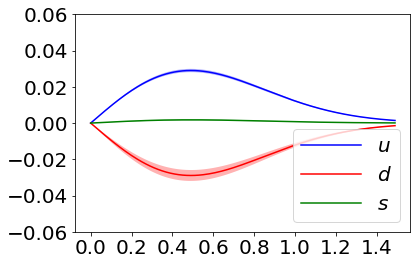

In [8]:
plotSivDistBands(10, 0.1, 2.4, .57, -2, np.array(list(range(150)))/100)

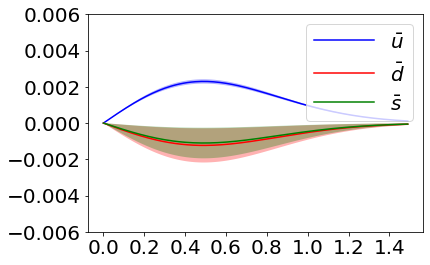

In [9]:
plotSivDistBandsSea(10, 0.1, 2.4, .57, -2, np.array(list(range(150)))/100)

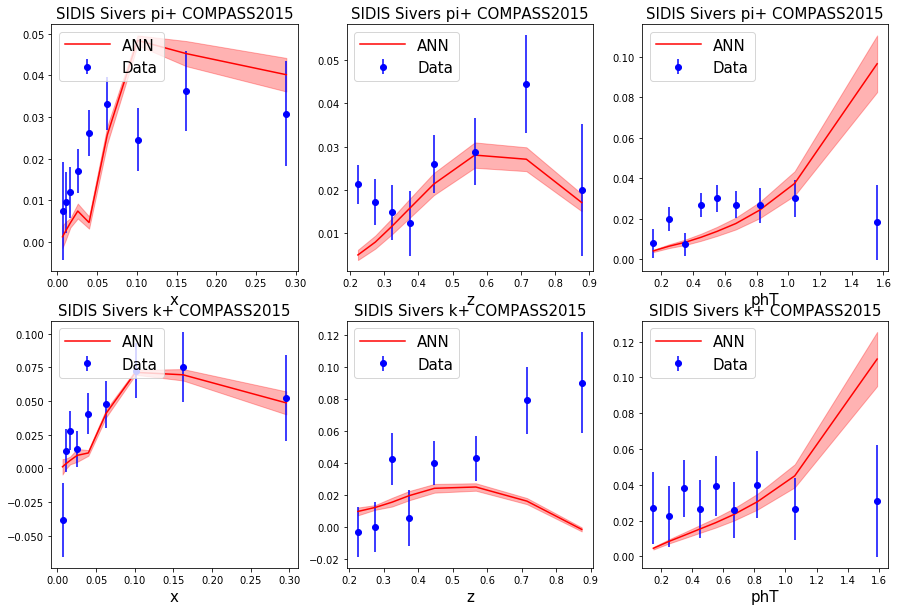

In [12]:
#### Making Plots of Sivers Function ################


herm9 = pd.read_csv('./Data/HERMES_p_2009.csv').dropna(axis=0, how='all').dropna(axis=1, how='all')
herm20 = pd.read_csv('./Data/HERMES_p_2020.csv').dropna(axis=0, how='all').dropna(axis=1, how='all')
comp9 = pd.read_csv('./Data/COMPASS_d_2009.csv').dropna(axis=0, how='all').dropna(axis=1, how='all')
comp15 = pd.read_csv('./Data/COMPASS_p_2015.csv').dropna(axis=0, how='all').dropna(axis=1, how='all')

######################################################################################
############### HERE the User need to define: plots for which data set (kinematics)### 
######################################################################################

dfsingle = pd.concat([comp15])


def calc_yhat(model, X):
    return model.predict(X)


class A0(tf.keras.layers.Layer):
    def __init__(self, kperp2avg=.57, pperp2avg=.12, **kwargs):
        super(A0, self).__init__(name='a0')
        self.m1 = tf.Variable(1., name='m1')
        self.kperp2avg = kperp2avg
        self.pperp2avg = pperp2avg
        self.e = tf.constant(1.)
        
    def get_config(self):
        config = super().get_config().copy()
        
        config.update({
            'kperp2avg': self.kperp2avg,
            'pperp2avg': self.pperp2avg
        })
        
        return config
        
    def call(self, inputs):
        z = inputs[:, 0]
        pht = inputs[:, 1]
        ks2avg = (self.kperp2avg*self.m1**2)/(self.m1**2 + self.kperp2avg) #correct 
        topfirst = (z**2 * self.kperp2avg + self.pperp2avg) * ks2avg**2 #correct
        bottomfirst = (z**2 * ks2avg + self.pperp2avg)**2 * self.kperp2avg #correct
        exptop = pht**2 * z**2 * (ks2avg - self.kperp2avg) #correct
        expbottom = (z**2 * ks2avg + self.pperp2avg) * (z**2 * self.kperp2avg + self.pperp2avg) #correct
        last = tf.sqrt(2*self.e) * z * pht / self.m1 #correct      
        return (topfirst/bottomfirst) * tf.exp(-exptop/expbottom) * last
    
    
class Quotient(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(Quotient, self).__init__()
    
    def call(self, inputs):
        if len(inputs) != 2 or inputs[0].shape[1] != 1:
            raise Exception('must be two tensors of shape (?, 1)')
        return inputs[0]/inputs[1]
    
    

class DataANN(object):
    def __init__(self, pdfset='cteq61',
                 ff_PIp='NNFF10_PIp_nlo', ff_PIm='NNFF10_PIm_nlo', ff_PIsum='NNFF10_PIsum_nlo',
                 ff_KAp='NNFF10_KAp_nlo', ff_KAm='NNFF10_KAm_nlo'):
        '''
        Get data in proper format for neural network
        '''
        self.pdfData = lhapdf.mkPDF(pdfset)
        self.ffDataPIp = lhapdf.mkPDF(ff_PIp, 0)
        self.ffDataPIm = lhapdf.mkPDF(ff_PIm, 0)
        self.ffDataPIsum = lhapdf.mkPDF(ff_PIsum, 0)
        self.ffDataKAp = lhapdf.mkPDF(ff_KAp, 0)
        self.ffDataKAm = lhapdf.mkPDF(ff_KAm, 0)
        # needs to be extended to generalize for kaons
        self.eu = 2/3
        self.eubar = -2/3
        self.ed = -1/3
        self.edbar = 1/3
        self.es = -1/3
        self.esbar = 1/3
        
        self.ffDict = {0: self.ffDataPIp,
                       1: self.ffDataPIm,
                       2: self.ffDataPIsum,
                       3: self.ffDataKAp,
                       4: self.ffDataKAm}
    

    def pdf(self, flavor, x, QQ):
        return np.array([self.pdfData.xfxQ2(flavor, ax, qq) for ax, qq in zip(x, QQ)])
    
    
    def ff(self, func, flavor, z, QQ):
        return np.array([func.xfxQ2(flavor, az, qq) for az, qq in zip(z, QQ)])    
    

    def makeData(self, dfsingle, hadrons, dependencies):
        
        data = {'x': [],
             'z': [],
             'phT': [],
             'uexpr': [],
             'ubarexpr': [],
             'dexpr': [],
             'dbarexpr': [],
             'sexpr': [],
             'sbarexpr': []}
        
        y = []
        err = []
        
        dfsingle = dfsingle.loc[dfsingle['hadron'].isin(hadrons), :]
        dfsingle = dfsingle.loc[dfsingle['1D_dependence'].isin(dependencies), :]
        #X = np.array(df[['x', 'z', 'phT', 'Q2', 'hadron']])
        for i, had in enumerate(['pi+', 'pi-', 'pi0', 'k+', 'k-']):
            sliced = dfsingle.loc[dfsingle['hadron'] == had, :]
            y += list(sliced['Siv'])
            err += list(sliced['tot_err'])
            
            x = sliced['x']
            z = sliced['z']
            QQ = sliced['Q2']
            data['uexpr'] += list(self.eu**2 * self.pdf(2, x, QQ) * self.ff(self.ffDict[i], 2, z, QQ))
            data['ubarexpr'] += list(self.eubar**2 * self.pdf(-2, x, QQ) * self.ff(self.ffDict[i], -2, z, QQ))
            data['dexpr'] += list(self.ed**2 * self.pdf(1, x, QQ) * self.ff(self.ffDict[i], 1, z, QQ))
            data['dbarexpr'] += list(self.edbar**2 * self.pdf(-1, x, QQ) * self.ff(self.ffDict[i], -1, z, QQ))
            data['sexpr'] += list(self.es**2 * self.pdf(3, x, QQ) * self.ff(self.ffDict[i], 3, z, QQ))
            data['sbarexpr'] += list(self.esbar**2 * self.pdf(-3, x, QQ) * self.ff(self.ffDict[i], -3, z, QQ))

            data['x'] += list(x)
            data['z'] += list(z)
            data['phT'] += list(sliced['phT'])
        
        for key in data.keys():
            data[key] = np.array(data[key])
        
        return data, data[dependencies[0]], np.array(y), np.array(err)
    
        
datann = DataANN()

def SiversAsym(numReplicas,hadron,dependence):
    T_Xplt, T_DEP, T_yplt, T_errplt = datann.makeData(dfsingle, [hadron], [dependence])
    results = []
    for i in range(numReplicas):
        testmodel = tf.keras.models.load_model('Models_SIDIS_10/rep' + str(i) + '.h5',custom_objects={'A0': A0, 'Quotient': Quotient})
        results.append(list(calc_yhat(testmodel, T_Xplt)))
    return np.array(results)


def plotSivAsymmBands(numReplicas,hadron,dependence, numSigma=2):
    T_Xplt, T_DEP, T_yplt, T_errplt = datann.makeData(dfsingle, [hadron], [dependence])
    results = SiversAsym(numReplicas,hadron,dependence)
    Yhat = np.array(results.mean(axis=0))
    Yhat = Yhat.flatten()
    Yerr = np.array(results.std(axis=0))
    Yerr = Yerr.flatten()
    plt.fill_between(T_DEP, Yhat-numSigma*Yerr, Yhat+numSigma*Yerr, color='r', alpha=0.3)
    plt.errorbar(T_DEP, T_yplt,yerr=T_errplt, fmt='bo',label='Data')
    plt.plot(T_DEP, Yhat, 'r',label='ANN')
    #### Here the user needs to define the plot title based on the data set ####
    plt.title('SIDIS Sivers '+str(hadron)+' COMPASS2015',fontsize=15)
    plt.xlabel(str(dependence),fontsize=15)
    plt.legend(loc=2,fontsize=15,handlelength=3)


    
fig1=plt.figure(1,figsize=(15,10))
plt.subplot(2,3,1)
plotSivAsymmBands(10,'pi+','x')
plt.subplot(2,3,2)
plotSivAsymmBands(10,'pi+','z')
plt.subplot(2,3,3)
plotSivAsymmBands(10,'pi+','phT')
plt.subplot(2,3,4)
plotSivAsymmBands(10,'k+','x')
plt.subplot(2,3,5)
plotSivAsymmBands(10,'k+','z')
plt.subplot(2,3,6)
plotSivAsymmBands(10,'k+','phT')
#### Here the user needs to define the plot title based on the data set ####
plt.savefig('COMPASS2015Asymmetries_ANN.pdf', format='pdf', bbox_inches='tight')


#print(SiversAsym(10,'pi+','phT'))
#Xplt, DEP, yplt, errplt = datann.makeData(dfsingle, ['pi+'], ['phT'])
#print(DEP)
#testmodel = tf.keras.models.load_model('Models_SIDIS_New100/rep' + '0' + '.h5', 
#                                         custom_objects={'A0': A0, 'Quotient': Quotient})
#yhatplt = calc_yhat(testmodel, Xplt)
#print(yhatplt)

In [3]:
np.array(list(range(150)))/100

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07, 1.08, 1.09,
       1.1 , 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18, 1.19, 1.2 ,
       1.21, 1.22, 1.23, 1.24, 1.25, 1.26, 1.27, 1.28, 1.29, 1.3 , 1.31,
       1.32, 1.33, 1.34, 1.35, 1.36, 1.37, 1.38, 1.39, 1.4 , 1.41, 1.42,
       1.43, 1.44, 1.45, 1.46, 1.47, 1.48, 1.49])